# It's a Start

### Imports

In [18]:
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

### Creative liberties

hahahah 

As we don't have all of the facts / estimates yet, I'll have to take... creative liberties.

I'll say that the café is open from 06:30 to 15:30, that the main rush hour is between 8 and 9, and that there's then another lesser rush during lunch (11:30 to 13:00).

So, essentially:

| Time | Customers per hour (arrival rate (lambda)) |
| ---- | ------------------------------------------ |
| 06:30 - 08:00 | 10 |
| 08:00 - 09:00 | 50 (rush) |
| 09:00 - 11:30 | 20 |
| 11:30 - 13:00 | 40 (lesser rush) |
| 13:00 - 15:30 | 15 |

... so this would be a "non-homogeneous" Poisson process, which SimPy DOES NOT have built in. So I'll be implementing it.

In [19]:
## Note: We could also hard-code things a bit more like so, but we probably shouldn't.
# rates = {
#     90: 10/60,  # 06:30 - 08:00 --> 90 minutes. 
#     150: 50/60, # 08:00 - 09:00 --> 90+60 = 150 minutes
#     330: 20/60, # And so on.
#     390: 40/60, 
#     540: 15/60  # - 15:30, end of day.
# }


closing_time = 540 # The café is open for 9 hours.

def arrival_rate(time):
    '''
    Arrival rate in customers per --> minute <--.
    Should peak at around 120 minutes in, that's 08:30.
    '''

    baseline = 0.067    # Circa 4 customers per hour.
    peak = 0.34         # Circa 20 customers per hour.
    rush = 120          # That's 08:30
    rush_length = 60    # Length of rush hour (1 hour).

    return (baseline +   (peak *   (np.exp(-((time-rush)**2) / (2*(rush_length**2))))   )   )

# We'll want to not do things like this.

### Metrics that I'm going to keep track of: a checklist.

1) How long customers have to wait, from when they arrive at the café to when they pick up their order.
    - Would also be nice to see how long customers wait in each "act" (waiting to order + ordering, waiting for their order, picking up their order).  
2) How well all resources are utilized (employees in particular), how much idle time they have.

In [20]:
class Stats:
    def __init__(self):
        # CUSTOMER TIME-TRACKING
        self.register_queue_time = []           # Time each customer spent waiting to place their order.
        self.pickup_queue_time = []             # Time each custimer spent picking up their order.
        self.total_time_in_system = []          # Total time each customer spent from arrival time to pickup time.
        
        self.time_until_prep_begins = []        # The time from the customer places the order until a barista begins working on it.

        self.arrival_times = []                 # For plotting.

        # OTHER CUSTOMER-RELATED MEASURES
        self.avg_length_register_queue = []     # This is a list because we might also want to graph this. Average length of queue per every hour, or something.
        self.avg_length_pickup_queue = []       # I don't think this has ever not been 0. I'm tracking it for the sake of consistency, though.
        self.avg_count_customers_waiting = []   # Could also be cool to graph.

        # TODO: RESOURCE UTILIZATION


### Time distributions defined

*Needs revision

In [21]:
# Once again, we have yet to pin down the service time distribution,
# but to start implementing I'll just assume that it takes at least 5 seconds
# and that the mean is 45 seconds with a standard deviation of 10. Or something.
def order_time(rng):
    '''How long it takes a customer to order, in seconds.'''
    return max(5, rng.normal(45, 10)) 



# ... it's gotta take at least 5 seconds, that's if you're just taking out a croissant and putting it on a dish or something.
# I'll just take a wild guess of 3 minutes (180 seconds) as the mean and 20 seconds as the standard deviation.
# Also I added the time it takes to pay. 
def making_order_time(rng):
    '''How long it takes to get the order ready.
    TODO: We might want to change this process later, add coffe machines and such as resources, and so on.
    For now though, it's just a distribution like so.'''

    #       Time taken to order             Time taken to pay
    return (max(10, rng.normal(180, 20)) + max(3, rng.normal(7, 3)))



# It's gotta take at least a second.
# I'm just going to be optimistic and guess that the mean is 5 seconds, and the std is 1.
def pickup_time(rng):
    '''How long it takes the customer to pick up the order.'''
    return max(1, rng.normal(5, 1))

### Meatier functions

In [22]:

def customer(env, stats_keeper, ID, register, barista, pickup, rng):
    '''Customer's "lifecycle".
    They arrive, wait in line, order + pay, wait for their order, and then pick up their order.
    
    Params:
        - env:          simpy.Environment.
        - ID:           int, customer's ID.
        - register:     int, ID of the register they queue at.
        - rng:          RNG.

    Returns:
        - everlasting happiness

    '''

    arrival = env.now
    print(f'{ID} arrives at {arrival:.2f}')

    # TODO: I could refactor these "acts" into different function. For readibility. 

    # # # # # # # # # # # # # # 
    #   ACT I: The Register   #
    # # # # # # # # # # # # # # 
    with (register.request() as req):
        yield req # Waiting in line.

        start_ordering = env.now

        print(f"{ID} begins ordering at {start_ordering:.2f}")

        # We wait while the customer places their order.
        ordering = order_time(rng)
        yield env.timeout(ordering)

        stop_ordering = env.now
        print(f"{ID} finishes ordering at {stop_ordering:.2f}")

    # # # # # # # # # # # # # # 
    #   ACT II: The Waiting   #
    # # # # # # # # # # # # # # 
    with (barista.request() as req):
        yield req

        prep_time = making_order_time(rng)
        prep_begin = env.now
        print(f"{ID}'s order preperation begins at {prep_begin:.2f}")

        yield env.timeout(prep_time)
        time_ready = env.now
        print(f"{ID}'s is ready for pickup at {time_ready:.2f}")


    # # # # # # # # # # # # # # 
    #   ACT III: The Pickup   #
    # # # # # # # # # # # # # #
    with pickup.request() as req:
        yield req

        start_pickup = env.now
        print(f"{ID} goes to pick up their order at {start_pickup:.2f}")

        pickupp_time = pickup_time(rng)
        yield env.timeout(pickupp_time)

        end_time = env.now
        print(f"{ID} leaves at {end_time:.2f}")

    # # # # # # # # # # # # # # #
    #   ALSO: Gathering Stats   #
    # # # # # # # # # # # # # # #

    time_in_register_queue = (start_ordering - arrival)
    time_in_pickup_queue = (time_ready - start_pickup)
    total_time = end_time - arrival
    stats_keeper.register_queue_time.append(time_in_register_queue)  # TODO: Do we maybe want :.2f?
    stats_keeper.pickup_queue_time.append(time_in_pickup_queue)
    stats_keeper.total_time_in_system.append(total_time)

    time_from_order_to_prep_start = time_ready - prep_begin
    stats_keeper.time_until_prep_begins.append(time_from_order_to_prep_start)


In [23]:

def arrivals_generator(env, stats_keeper, register, barista, pickup, arrival_rate, closing_time, seed=None):
    '''
    Generates customer arrival times using a
        PIECEWISE-CONSTANT NON-HOMOGENEOUS POISSON PROCESS.

    Params:
        - env:      simpy.Environment.
        - rates:    a dictionary, the keys being time passed (breakpoints) in minutes 
                    and the values being arrival rates.
        - seed:     int, seed for RNG.

    Returns:
        - Arrivals. Floats.
    '''

    rng = np.random.default_rng(seed)
    #breakpoints = sorted(rates.keys())
    #
    #def get_rate(time):
    #    '''Returns arrival rate for current time, however we defined it.'''
    #    for point in breakpoints:
    #        if (time < point):
    #            return rates[point]
    #    return rates[breakpoints[-1]] # If past all, just use the last one.


    customer_ID = 0
    inter_arrival = 0
    while True:

        if ((env.now + inter_arrival) >= closing_time):
            print(f"\nCLOSING SHOP. \nNo more arrivals after closing at {closing_time:.2f}.\n")
            return

        #rate = get_rate(env.now)                    # Rate at this time.
        rate = arrival_rate(env.now)

        inter_arrival = rng.exponential(1 / rate)   # Inter arrival from exponential dist.
        yield env.timeout(inter_arrival)            # Waiting until the next arrival.

        arrival_time = env.now                      # For plotting.
        stats_keeper.arrival_times.append(arrival_time)

        env.process(customer(
            env, 
            stats_keeper,
            customer_ID, 
            register, 
            barista,
            pickup,
            rng
        ))
        customer_ID += 1

I should probably add a short description above each function. Readibility reasons.

In [24]:
def simulate(num_registers, num_baristas, num_pickups, arrival_rate, closing_time, ttl):
    '''
    Simulates the process with the specified:
        - num_registers:    int, number of registers / staff at registers.
        - num_baristas:     int, number of baristas (those preparing orders).
        - num_pickups:      int, number of places where drinks can be picked up.
        - rates:            dict, the customers-per-hour rate for each period of time.
        - closing_time:     int, this is when new customers should stop coming in. This is just when we stop taking orders.
        - ttl:              number, "time-to-live", how long the simulation will be allowed to run (in case there are some customers still awaiting their orders).

    Returns:
        - statistics:       Stats class object. Just stats for this particular run.
    '''
    
    env = simpy.Environment()
    statistics = Stats()

    register = simpy.Resource(env, capacity=num_registers)      # Note: SimPy resources are FIFO by default.
    barista = simpy.Resource(env, capacity=num_baristas)        # We have [CAPACITY] amount of baristas, each can focus on one order at a time.
    pickup = simpy.Resource(env, capacity=num_pickups)          # One can pick up their order at a time.

    env.process(arrivals_generator(
        env=env, 
        stats_keeper=statistics,
        register=register, 
        barista=barista,
        pickup=pickup,
        arrival_rate=arrival_rate,
        closing_time=closing_time,
        seed=360
    ))
    env.run(until=ttl)  # TODO: NOTE: way beyond closing time. I just wanted to see how much would be done in this time. People stop coming in after closing.

    return statistics


In [25]:
def print_stats(statistics):
    print("Total times in register queue:\n", statistics.register_queue_time)
    print("Time from when the order is placed until a barista begins working on it:\n", statistics.time_until_prep_begins)
    print("Total times in pickup queue:\n", statistics.pickup_queue_time)
    print("Total times in system:\n", statistics.total_time_in_system)
    # We'll want to add more.

In [26]:
def plot_stats(statistics):
    plt.plot(statistics.total_time_in_system)
    plt.ylabel('Waiting time for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.register_queue_time)
    plt.ylabel('Waiting time in register queue for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.pickup_queue_time)
    plt.ylabel('Waiting time in pickup queue for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.time_until_prep_begins)
    plt.ylabel('Waiting time until barista begins working on order for customers 0 to i')
    plt.show()

In [27]:
def plot_arrivals(statistics):
    '''
    Plots arrivals as a scatter plot + rate histogram.
    '''
    arrivals = statistics.arrival_times
    
    plt.figure(figsize=(10,4))

    # Scatter plot
    plt.scatter(arrivals, [0]*len(arrivals), s=10)
    plt.title("Customer Arrival Times")
    plt.xlabel("Time (minutes)")
    plt.yticks([])
    plt.show()

    # Histogram
    plt.figure(figsize=(10,4))
    plt.hist(arrivals, bins=30)
    plt.xlabel("Time (minutes)")
    plt.ylabel("# Arrivals")
    plt.title("Histogram of Arrivals")
    plt.show()


## Default run, default values

We start out with:
| Number | Resource | Explanation |
| ------ | -------- | ----------- |
| 1 | Register | Order-takers |
| 2 | Barista | Order-preparers |
| 1 | Pickup station | Where customers pick up their orders |

* We'll want to define more, obviously.

In [28]:
default = simulate(1, 2, 1, arrival_rate, closing_time, 1000)

0 arrives at 4.28
0 begins ordering at 4.28
1 arrives at 15.08
2 arrives at 21.66
3 arrives at 24.08
4 arrives at 26.50
5 arrives at 26.74
6 arrives at 42.88
0 finishes ordering at 46.04
0's order preperation begins at 46.04
1 begins ordering at 46.04
7 arrives at 47.09
8 arrives at 48.50
9 arrives at 61.70
10 arrives at 62.78
11 arrives at 62.92
12 arrives at 66.77
13 arrives at 70.35
14 arrives at 74.78
15 arrives at 77.94
16 arrives at 81.51
17 arrives at 94.15
18 arrives at 94.43
19 arrives at 96.23
20 arrives at 98.91
21 arrives at 99.84
22 arrives at 100.12
1 finishes ordering at 101.85
1's order preperation begins at 101.85
2 begins ordering at 101.85
23 arrives at 109.13
24 arrives at 110.19
25 arrives at 112.14
26 arrives at 115.29
27 arrives at 116.93
28 arrives at 118.84
29 arrives at 119.38
30 arrives at 120.63
31 arrives at 123.13
32 arrives at 128.30
33 arrives at 130.48
34 arrives at 131.07
35 arrives at 131.57
36 arrives at 132.17
37 arrives at 132.57
38 arrives at 134.

#### Stats Display

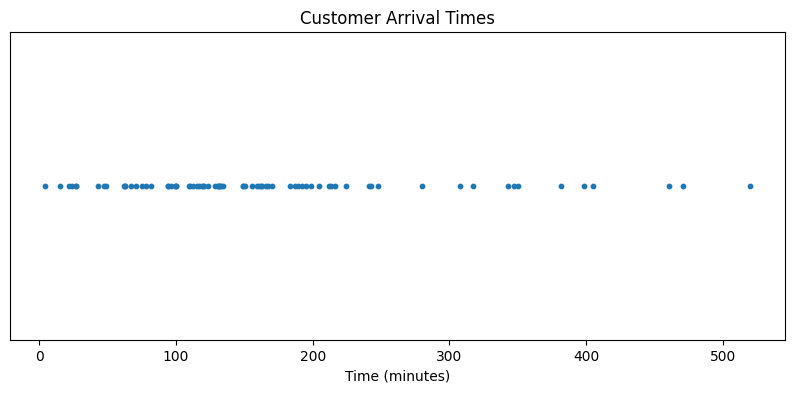

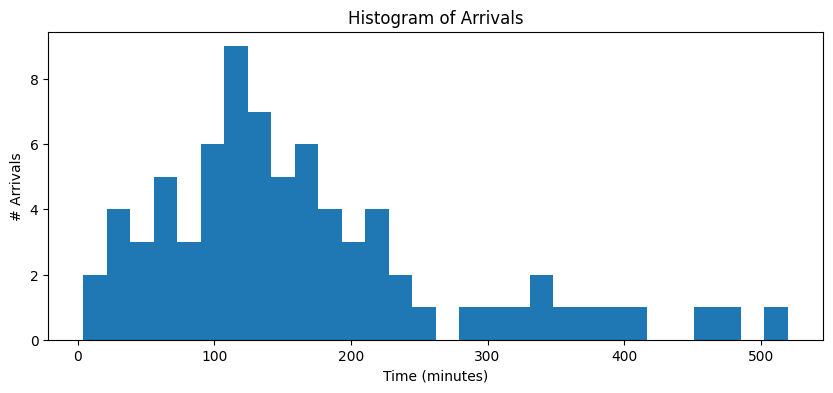

Total times in register queue:
 [0.0, 30.96438641637601, 80.19318076605926, 125.26955926678687, 208.1703701373115, 174.7777998643817, 231.4932870157724, 248.7710275951262]
Time from when the order is placed until a barista begins working on it:
 [188.50218360721612, 178.60890685442158, 208.1881876749854, 166.4186896223216, 217.2991096201746, 231.37373947806998, 174.4028632282159, 178.7940461422928]
Total times in pickup queue:
 [0.0, 0.0, 0.0, -0.2216609639069702, 0.0, 0.0, 0.0, 0.0]
Total times in system:
 [234.00448345792339, 271.42906243240725, 425.4424382067094, 428.73092109190776, 641.7722951792739, 653.2264340504912, 801.723965837772, 810.3478812553726]


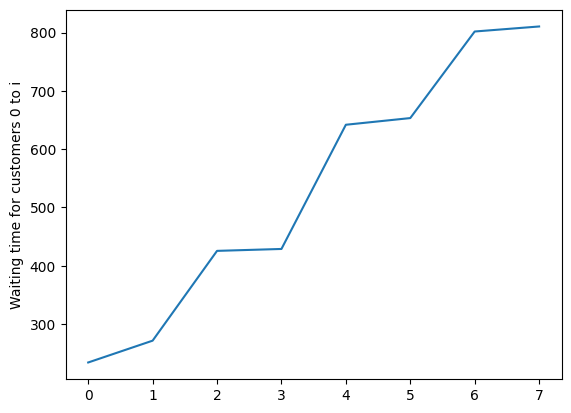

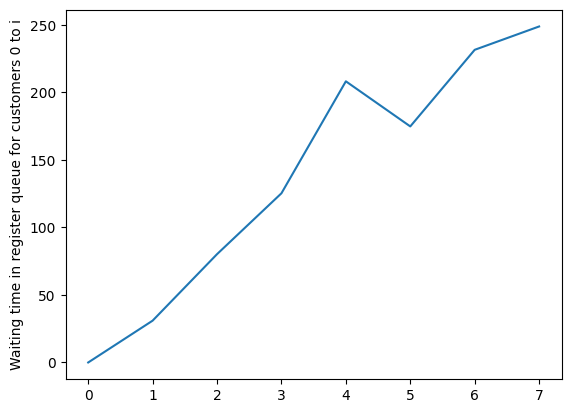

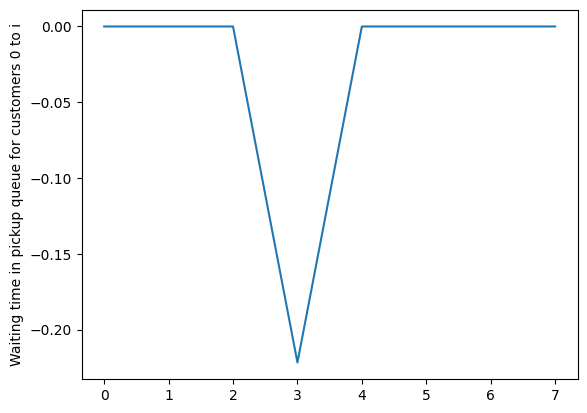

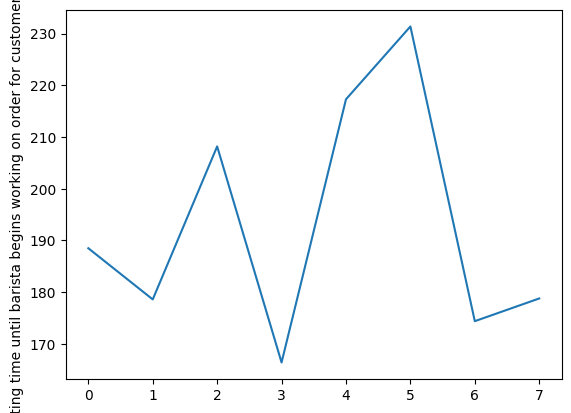

In [29]:
plot_arrivals(default)
print_stats(default)
plot_stats(default)

*Insert thoughtful discussion of results.

# Experiment #1: Add one more register.

In [30]:
exp_1 = simulate(2, 2, 1, arrival_rate, closing_time, 1000)

0 arrives at 4.28
0 begins ordering at 4.28
1 arrives at 15.08
1 begins ordering at 15.08
2 arrives at 21.66
3 arrives at 24.17
4 arrives at 24.42
5 arrives at 41.15
6 arrives at 45.47
0 finishes ordering at 46.04
0's order preperation begins at 46.04
2 begins ordering at 46.04
1 finishes ordering at 48.11
1's order preperation begins at 48.11
3 begins ordering at 48.11
7 arrives at 53.72
8 arrives at 58.06
9 arrives at 62.04
10 arrives at 66.91
11 arrives at 70.35
12 arrives at 74.21
13 arrives at 87.73
14 arrives at 88.03
2 finishes ordering at 89.65
4 begins ordering at 89.65
15 arrives at 89.90
16 arrives at 90.88
17 arrives at 91.18
18 arrives at 100.65
19 arrives at 101.41
20 arrives at 105.40
3 finishes ordering at 106.88
5 begins ordering at 106.88
21 arrives at 113.05
22 arrives at 115.00
23 arrives at 118.14
24 arrives at 119.77
25 arrives at 121.68
26 arrives at 122.22
27 arrives at 123.47
28 arrives at 125.97
29 arrives at 131.16
30 arrives at 133.35
31 arrives at 133.94
32

#### Stats display

Total times in register queue:
 [0.0, 0.0, 23.94359827603875, 24.387749063557127, 65.72294607242696, 65.22946707722039, 96.3822346672092, 101.84127031007316, 111.51140907414624, 155.09027926943725]
Time from when the order is placed until a barista begins working on it:
 [162.89767525535083, 175.46491668519064, 178.10362943587893, 191.42760113882, 217.2991096201746, 231.37373947806998, 155.31624835733555, 166.13192706068912, 168.00998919148776, 151.14924273487838]
Total times in pickup queue:
 [0.0, 0.0, 0.0, -1.5415586143381006, 0.0, 0.0, 0.0, 0.0, 0.0, -1.7133839053526572]
Total times in system:
 [199.14688973382894, 220.0310651139603, 379.8104332845477, 388.0371035374714, 582.4720424349841, 612.5947490943624, 736.6341112351314, 748.9830784538141, 891.9241231342148, 892.3839963650792]


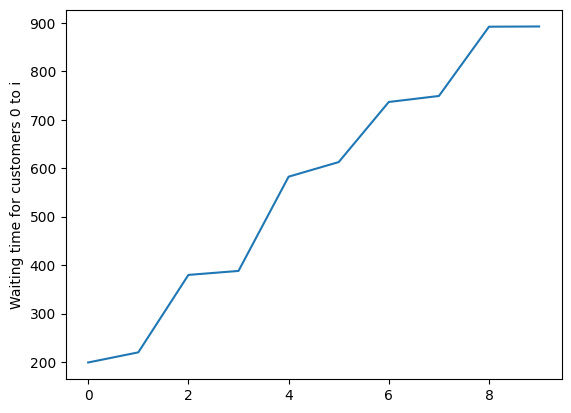

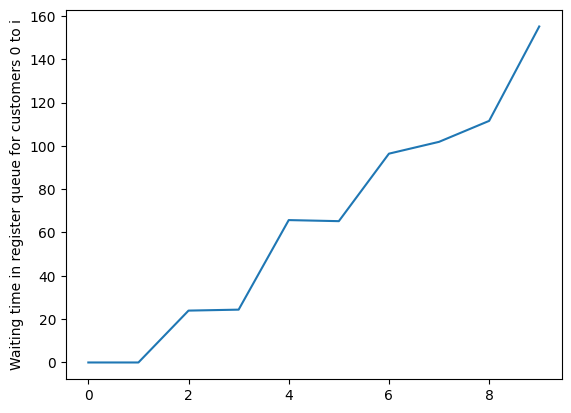

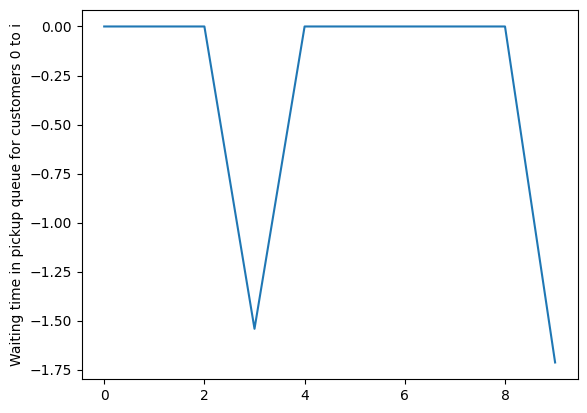

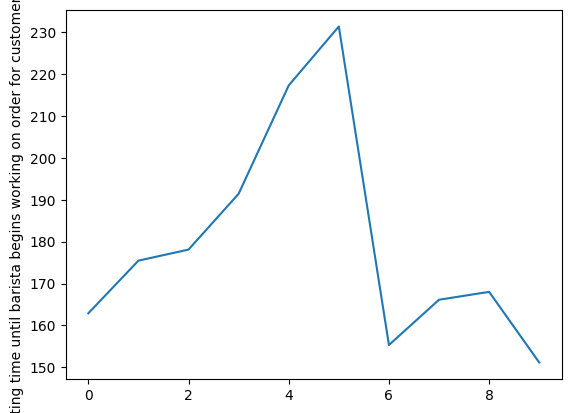

In [31]:
print_stats(exp_1)
plot_stats(exp_1)

... well something went wrong here. A negative number of waiting? How?
Adding a register also doesn't really seem to be making things significantly better.

# Experiment #2: Impossible numbers.

In [32]:
exp_2 = simulate(100, 100, 100, arrival_rate, closing_time, 1000)

0 arrives at 4.28
0 begins ordering at 4.28
1 arrives at 15.08
1 begins ordering at 15.08
2 arrives at 21.66
2 begins ordering at 21.66
3 arrives at 24.17
3 begins ordering at 24.17
4 arrives at 40.97
4 begins ordering at 40.97
0 finishes ordering at 46.04
0's order preperation begins at 46.04
1 finishes ordering at 48.11
1's order preperation begins at 48.11
5 arrives at 49.78
5 begins ordering at 49.78
6 arrives at 49.94
6 begins ordering at 49.94
7 arrives at 54.38
7 begins ordering at 54.38
8 arrives at 58.41
8 begins ordering at 58.41
9 arrives at 61.79
9 begins ordering at 61.79
2 finishes ordering at 67.35
2's order preperation begins at 67.35
3 finishes ordering at 68.08
3's order preperation begins at 68.08
10 arrives at 77.34
10 begins ordering at 77.34
4 finishes ordering at 78.58
4's order preperation begins at 78.58
7 finishes ordering at 79.10
7's order preperation begins at 79.10
5 finishes ordering at 84.08
5's order preperation begins at 84.08
6 finishes ordering at 85

Total times in register queue:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Time from when the order is placed until a barista begins working on it:
 [162.89767525535083, 161.28262771859818, 176.33360080927184, 208.19184954271225, 161.4967699016696, 179.02627674818586, 190.37003245448443, 193.08197655765727, 198.10047997128657, 156.02227726599455, 204.44983543426227, 153.66886984308772, 180.7954376985074, 174.40286322821595, 187.87699054472856, 182.54901616478384, 180.49535644373157, 170.61360155090227, 172.73262635518597, 197.95123909758797, 194.75353565499972, 206.0029213239145, 167.6711529878013, 222.35576950392527, 177.81156696002506, 179.3345686782296, 167.0565985123104, 144

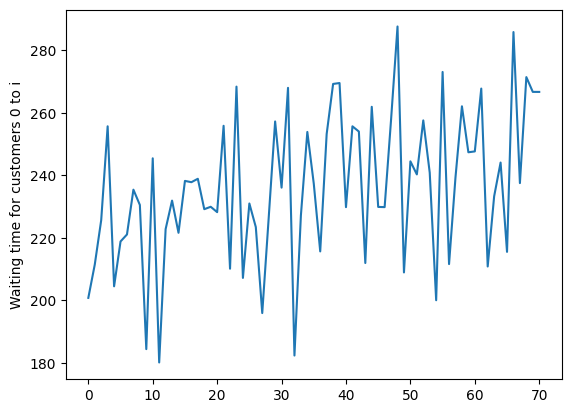

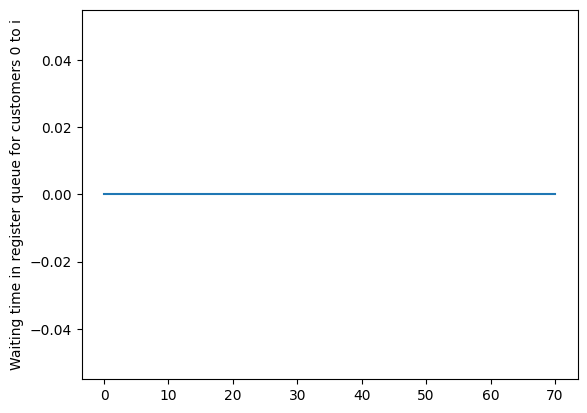

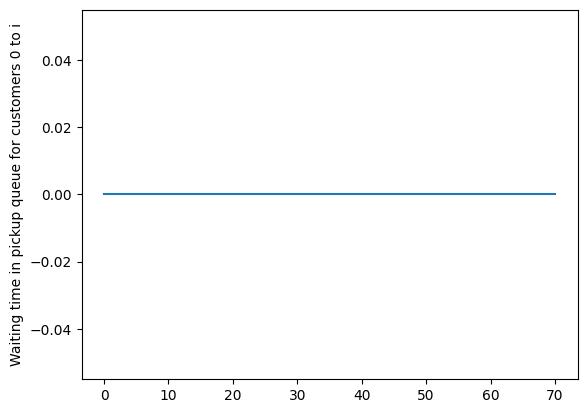

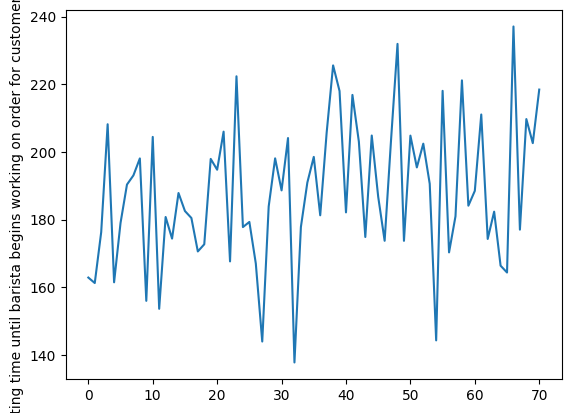

In [33]:
print_stats(exp_2)
plot_stats(exp_2)

Some analysis could probably be done here. But not today.

# TODOS:

*See Google Doc